## Use the `telco` dataset for modeling

In [43]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import acquire, prepare, wrangle, explore, model

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Load wranged telco data

train, validate, test = wrangle.wrangle_telco()
train.head()

,customer_id,monthly_charges,tenure,total_charges
728,4573-JKNAE,19.35,12,212.30
366,2229-DPMBI,19.50,8,162.15
262,1568-LJSZU,92.20,68,6392.85
1629,9661-JALZV,24.70,58,1519.00
568,3498-LZGQZ,19.15,63,1177.05


In [3]:
# Scale the features

columns_to_scale = ['monthly_charges', 'tenure']
train_scaled, validate_scaled, test_scaled = prepare.scale(train, validate, test, columns_to_scale)

train_scaled.head()

,customer_id,monthly_charges,tenure,total_charges,monthly_charges_scaled,tenure_scaled
728,4573-JKNAE,19.35,12,212.30,0.005503,0.154930
366,2229-DPMBI,19.50,8,162.15,0.007004,0.098592
262,1568-LJSZU,92.20,68,6392.85,0.734367,0.943662
1629,9661-JALZV,24.70,58,1519.00,0.059030,0.802817
568,3498-LZGQZ,19.15,63,1177.05,0.003502,0.873239


### Set up Baseline

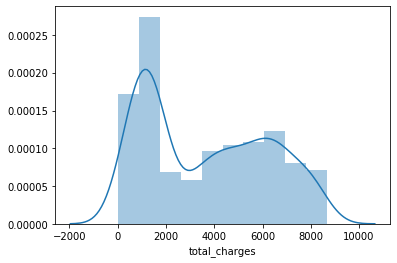

In [8]:
# Plot the distribution of target var: total_charges

sns.distplot(train_scaled.total_charges)

In [13]:
# Compute the mean and median of the total_charges

mean, median = train_scaled.total_charges.agg(['mean', 'median'])

mean, median

(3661.3474174428466, 3517.9)

In [34]:
# Compute baseline prediction using mean

baseline = np.array([mean]*train_scaled.shape[0])
baseline[:5], len(baseline)

(array([3661.34741744, 3661.34741744, 3661.34741744, 3661.34741744,
        3661.34741744]),
 1181)

In [62]:
# Compute baseline sse

baseline_residual = y_train - mean
baseline_sse = (baseline_residual**2).sum()
baseline_sse

total_charges    7.764795e+09
dtype: float64

In [63]:
# Compute baseline mse

baseline_mse = baseline_sse/train_scaled.shape[0]
baseline_mse

total_charges    6.574763e+06
dtype: float64

In [65]:
# Compute baseline rmse

baseline_rmse = mean_squared_error(y_train, baseline)**1/2
baseline_rmse

3287381.303240738

### LinearRegression()
- X: 
    - monthly_charges_scaled and tenure_scaled
    - monthly_charges_scaled
    - tenure_scaled
- y: total_charges

In [27]:
# Use both features for X

X_train_scaled = train_scaled[['monthly_charges_scaled', 'tenure_scaled']]
y_train = train_scaled[['total_charges']]

X_train_scaled.head()

,monthly_charges_scaled,tenure_scaled
728,0.005503,0.154930
366,0.007004,0.098592
262,0.734367,0.943662
1629,0.059030,0.802817
568,0.003502,0.873239


In [40]:
y_train.head()

,total_charges
728,212.30
366,162.15
262,6392.85
1629,1519.00
568,1177.05


In [31]:
y_train.shape

(1181, 1)

In [45]:
# Create LinearRegression() Object and fit the scaled train dataset

lm = LinearRegression(normalize=True)
lm.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [47]:
# Compute the predicted y

lm_pred = lm.predict(X_train_scaled)

In [49]:
# Compute the rmse of lm modeling

lm_rmse = mean_squared_error(y_train, lm_pred)**1/2
lm_rmse

121575.74320496806

In [66]:
# Call functions to calculate the model rmse of simple linear regression

model.compare_slr_metrics('total_charges', ['monthly_charges_scaled', 'tenure_scaled'], train_scaled)

,baseline_sse,model_sse,model_mse,model_rmse,r2,f_pval
monthly_charges_scaled,7.764795e+09,8.414758e+08,7.125113e+05,844.103823,0.891629,0.000000e+00
tenure_scaled,7.764795e+09,4.670772e+09,3.954930e+06,1988.700460,0.398468,2.743646e-132


**Takeways**
- Model_rmse in ascending order: `monthly_charges_scaled` --> `tenure_scaled` --> `both`

### LassoLars()
- X: monthly_charges_scaled and tenure_scaled
- y: total_charges

In [51]:
# Create, fit , predict

lars = LassoLars(alpha=0.1)
lars.fit(X_train_scaled, y_train)
lars_pred = lars.predict(X_train_scaled)

In [52]:
# Compute rmse of lars

lars_rmse = mean_squared_error(y_train, lars_pred)**1/2
lars_rmse

121584.1162081148

### PolynomialFeatures + LinearRegression
- 2nd degress polynomial
- X: monthly_charges_scaled and tenure_scaled
- y: total_charges

In [67]:
X_train_scaled.head()

,monthly_charges_scaled,tenure_scaled
728,0.005503,0.154930
366,0.007004,0.098592
262,0.734367,0.943662
1629,0.059030,0.802817
568,0.003502,0.873239


In [68]:
# Create, fit-transform

pf = PolynomialFeatures(degree=2)
X_train_scaled_squared = pf.fit_transform(X_train_scaled)

In [69]:
# fit and predict

lm_squared = LinearRegression()
lm_squared.fit(X_train_scaled_squared, y_train)
lm_squared_pred = lm_squared.predict(X_train_scaled_squared)

In [70]:
# Compute model rmse

lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**1/2
lm_squared_rmse

3718.5976275253383